In [63]:
import timeit 
from Ising_Model_Fast import *
import numpy as np
from numba import njit, prange

In [64]:
@njit(parallel=True)
def get_M_E_C_of_T_numba(lattice, energy, Ts, N, J1, J2, MC_steps, seed, use_last=1000):
    """Use Numba's parallelization for temperature loop"""
    n_temps = len(Ts)
    avg_mags = np.empty(n_temps, dtype=np.float32)
    avg_energies = np.empty(n_temps, dtype=np.float32)
    heat_capacities = np.empty(n_temps, dtype=np.float32)
    
    # Use prange for parallel execution
    for i in prange(n_temps):
        T = Ts[i]
        
        # Create a separate copy for each temperature
        local_lattice = lattice.copy()
        
        # Use deterministic but different seeds for each temperature
        local_seed = seed + i * 1000
        
        # Run the simulation
        mags, energies, _ = metropolis_large(
            local_lattice, 
            MC_steps, 
            T, 
            energy, 
            N, 
            J1, 
            J2, 
            local_seed
        )
        
        # Calculate statistics
        avg_mags[i] = np.mean(np.abs(mags[-use_last:]))
        avg_energies[i] = np.mean(energies[-use_last:])
        
        # Simple heat capacity calculation (may need to be replaced with your compute_specific_heat)
        e_mean = np.mean(energies[-use_last:])
        e2_mean = np.mean(energies[-use_last:]**2)
        heat_capacities[i] = (e2_mean - e_mean**2) / (N**2 * T**2)
    
    return avg_mags, avg_energies, heat_capacities

In [73]:
def simulate_all(p):
    Ns = [16, 32, 64, 128]
    Ts = np.linspace(1, 7, 20)
    J1, J2 = 0.5, 1.0
    MC_steps = 50_000
    seed = 3346

    p = 0.75

    lattices_N = [np.random.choice([1, -1], size=(N, N), p=[p, 1-p]) for N in Ns]
    lattices_N = [np.array(lattice, dtype=np.int8) for lattice in lattices_N]

    energies_N = [get_energy_fast(lattice, N, J1, J2) for lattice, N in zip(lattices_N, Ns)]
    energies_N = [np.array(energy, dtype=np.float32) for energy in energies_N]

    use_last = 1000

    n_Ns = len(Ns)
    n_Ts = len(Ts)

    avg_mags = np.empty((n_Ns, n_Ts), dtype=np.float32)
    avg_energies = np.empty((n_Ns, n_Ts), dtype=np.float32)
    heat_capacities = np.empty((n_Ns, n_Ts), dtype=np.float32)

    for i, N in enumerate(Ns):
        print(f"Running for N = {N}")
        lattice = lattices_N[i]
        energy = energies_N[i]
        avg_mags[i], avg_energies[i], heat_capacities[i] = get_M_E_C_of_T_numba(
            lattice, 
            energy, 
            Ts, 
            N, 
            J1, 
            J2, 
            MC_steps, 
            seed, 
            use_last=use_last
        )

    return Ns, Ts, avg_mags, avg_energies, heat_capacities

In [65]:
Ns = [16, 32, 64, 128]
Ts = np.linspace(1, 7, 20)
J1, J2 = 0.5, 1.0
MC_steps = 50_000
seed = 3346

p = 0.75

lattices_N = [np.random.choice([1, -1], size=(N, N), p=[p, 1-p]) for N in Ns]
lattices_N = [np.array(lattice, dtype=np.int8) for lattice in lattices_N]

energies_N = [get_energy_fast(lattice, N, J1, J2) for lattice, N in zip(lattices_N, Ns)]
energies_N = [np.array(energy, dtype=np.float32) for energy in energies_N]

use_last = 1000
burn_in = 0.1

In [66]:
n_Ns = len(Ns)
n_Ts = len(Ts)

avg_mags = np.empty((n_Ns, n_Ts), dtype=np.float32)
avg_energies = np.empty((n_Ns, n_Ts), dtype=np.float32)
heat_capacities = np.empty((n_Ns, n_Ts), dtype=np.float32)

for i, N in enumerate(Ns):
    print(f"Running for N = {N}")
    lattice = lattices_N[i]
    energy = energies_N[i]
    avg_mags[i], avg_energies[i], heat_capacities[i] = get_M_E_C_of_T_numba(
        lattice, 
        energy, 
        Ts, 
        N, 
        J1, 
        J2, 
        MC_steps, 
        seed, 
        use_last=use_last
    )

Running for N = 16
Running for N = 32
Running for N = 64
Running for N = 128


In [ ]:
p_p = 0.75
Ns, Ts, avg_mags_p, avg_energies_p, heat_capacities_p = simulate_all(p_p)

Running for N = 16
Running for N = 32


In [ ]:
p_n = 0.25
_, _, avg_mags_n, avg_energies_n, heat_capacities_n = simulate_all(p_n)

In [ ]:
def plot_results(Ts, avg_mags, avg_energies, heat_capacities):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(3, 1, figsize=(8, 10))

    axs[0].plot(Ts, avg_mags, label='Average Magnetization', color='blue', linestyle='--')
    axs[0].set_xlabel('Temperature (T)')
    axs[0].set_ylabel('Magnetization')
    axs[0].set_ylim(-0.05, 1.05)
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(Ts, avg_energies, label='Average Energy', color='red', linestyle='--')
    axs[1].set_xlabel('Temperature (T)')
    axs[1].set_ylabel('Energy')
    axs[1].legend()
    axs[1].grid()

    axs[2].plot(Ts, heat_capacities, label='Heat Capacity', color='green', linestyle='--')
    axs[2].set_xlabel('Temperature (T)')
    axs[2].set_ylabel('Heat Capacity')
    axs[2].legend()
    axs[2].grid()

    plt.tight_layout()
    plt.show()

Plotting results for N = 16


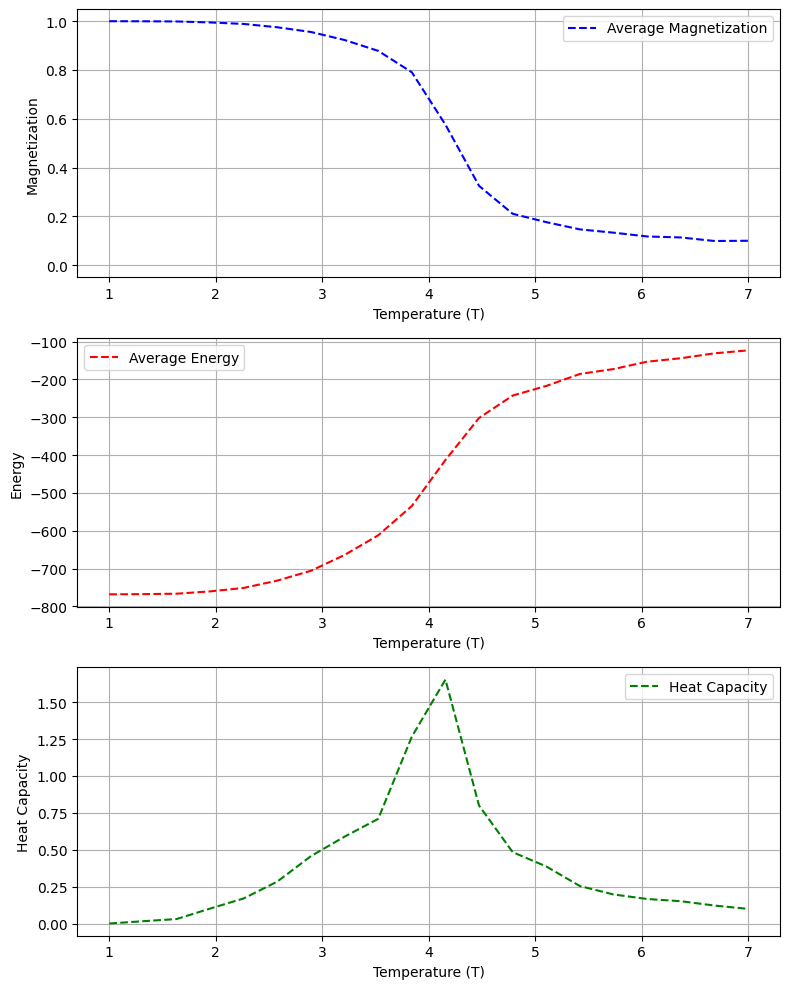

Plotting results for N = 32


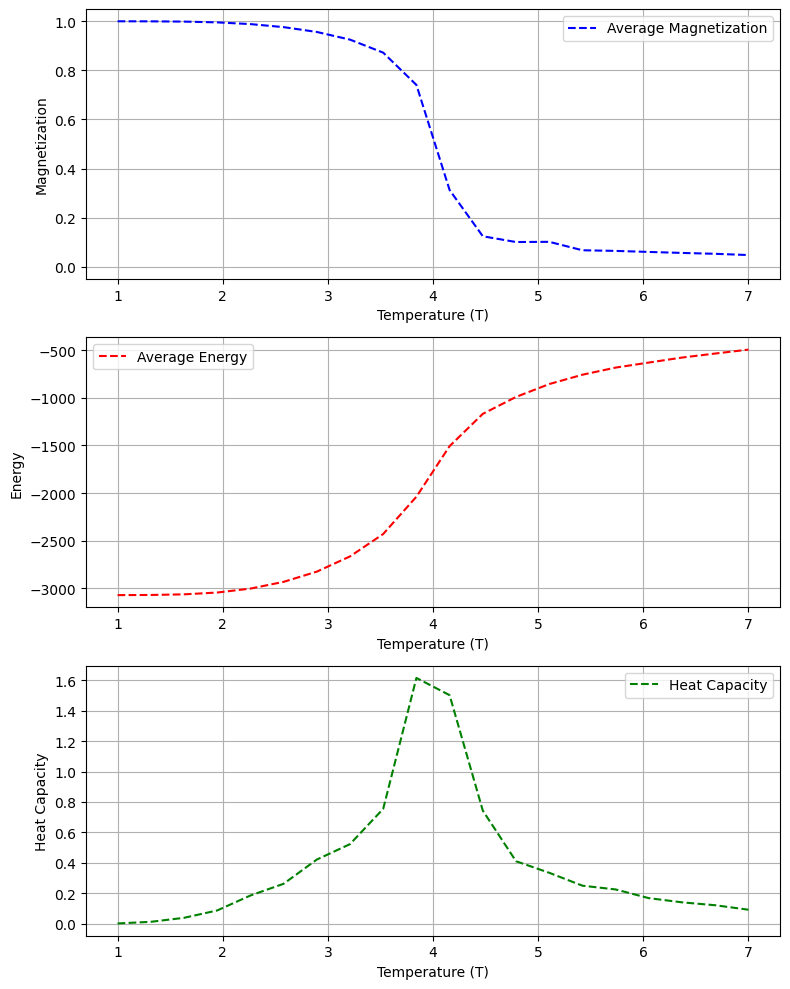

Plotting results for N = 64


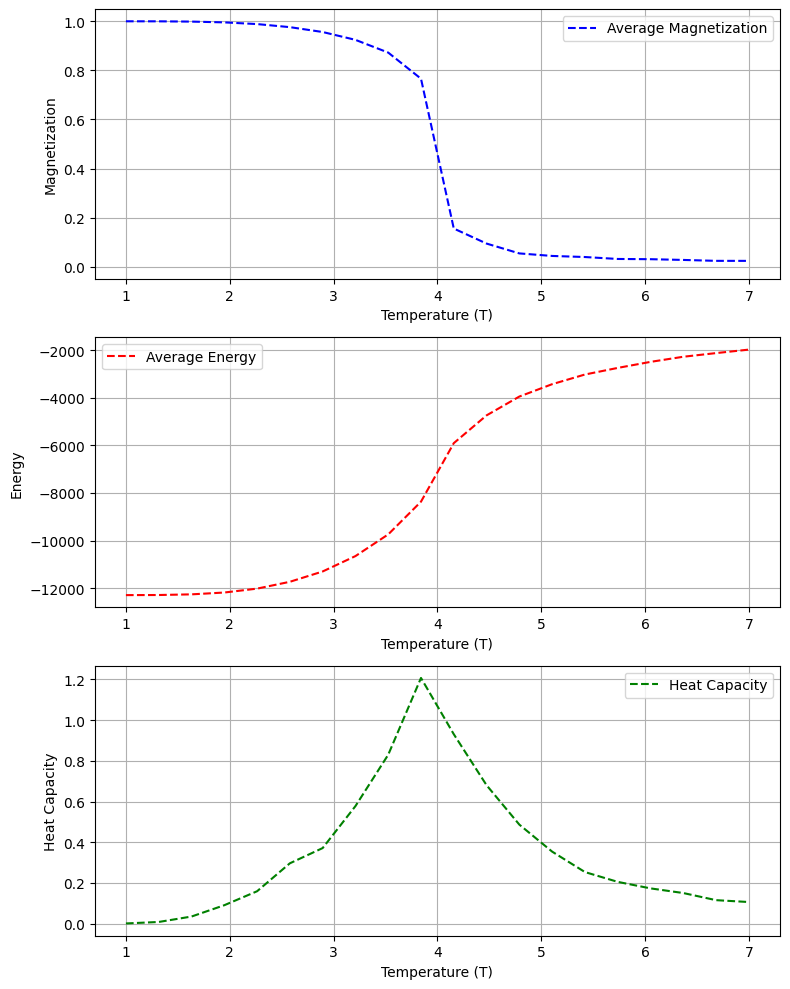

Plotting results for N = 128


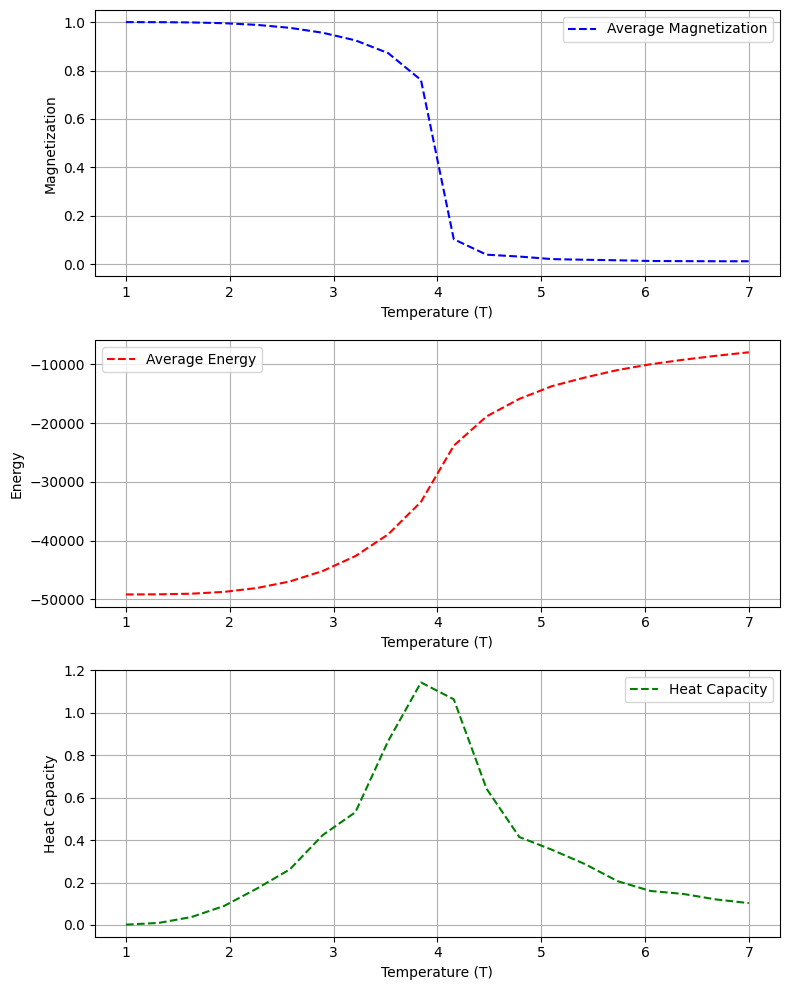

In [ ]:
for i, N in enumerate(Ns):
    print(f"Plotting results for N = {N}")
    plot_results(Ts, avg_mags[i], avg_energies[i], heat_capacities[i])